In [8]:
### IMPORT
from functools import reduce
from pathlib import Path
from typing import Counter

import xml.etree.ElementTree as ET
import re
from multiprocessing import Pool

from sqlalchemy import null

import matplotlib.pyplot as plt
from datetime import datetime
from pendulum import date

from os import path

In [18]:
from tensorboard import notebook

path.abspath('').replace('/notebook','/dataset')

'/home/fgpalacios/Documents/fpalacios/code/alkemy/Teams Alkemy/OT301-python/bigdata/datasets'

In [2]:
def chunckify(iterable, len_of_chunk):
    for i in range(0, len(iterable), len_of_chunk):
        yield iterable[i:i + len_of_chunk]

In [3]:
#Función para combinar listas
def fucionar_listas(data1, data2):
    data1.extend(data2)
    return data1

## Top10 preguntas con mayor tiempo de actividad
El Top10 se realiza a partir del calculo de la diferencia entre el la fecha de la creación de la pregunta (CreationDate) y la fecha de la ultima actividad de la misma (LastActivityDate)

In [4]:
def limpieza_datos(data):
    try:
        if data.attrib['PostTypeId'] == "1":
            titulo = data.attrib['Title']
            creacion = (data.attrib['CreationDate'])
            ultima_actividad = data.attrib['LastActivityDate']
            creacion = datetime.strptime(creacion, '%Y-%m-%dT%H:%M:%S.%f')
            ultima_actividad = datetime.strptime(ultima_actividad, '%Y-%m-%dT%H:%M:%S.%f')
            diferencia = ultima_actividad - creacion
            diferencia = int(diferencia.days)
            return diferencia, titulo
    except:
        return

In [5]:
def mapper_top(data):
    mapper = list(map(limpieza_datos, data))
    mapper = list(filter(None, mapper))
    return mapper

In [19]:
HOME_DIR = Path.home()

tree = ET.parse(fr"{path.abspath('').replace('/notebook','/dataset')}/posts.xml")
root = tree.getroot()
data_chunks = chunckify(root, 50)
mapped_top = list(map(mapper_top, data_chunks))
mapped_top = reduce(fucionar_listas, mapped_top)

In [20]:
#Exportación de los datos obtenidos, duración de cada posteo y titulo del mismo, ordenado de forma decendente
top10 = sorted(mapped_top, reverse=True)
top10 = top10[0:10]
with open((fr"{path.abspath('').replace('/notebook','/dataset')}/GD_r3_Top10_MayorTiempoDeActividad.csv"), 'w') as f:
        f.write(str(top10))                   
        f.close()

In [21]:
#Vicualización del top 10
print(f'''Top10 posteos con mayor tiempo de actividad: 
1) {top10[0][0]} dias activo. Titulo: {top10[0][1]}
2) {top10[1][0]} dias activo. Titulo: {top10[1][1]}
3) {top10[2][0]} dias activo. Titulo: {top10[2][1]}
4) {top10[3][0]} dias activo. Titulo: {top10[3][1]}
5) {top10[4][0]} dias activo. Titulo: {top10[4][1]}
6) {top10[5][0]} dias activo. Titulo: {top10[5][1]}
7) {top10[6][0]} dias activo. Titulo: {top10[6][1]}
8) {top10[7][0]} dias activo. Titulo: {top10[7][1]}
9) {top10[8][0]} dias activo. Titulo: {top10[8][1]}
10) {top10[9][0]} dias activo. Titulo: {top10[9][1]} ''')

Top10 posteos con mayor tiempo de actividad: 
1) 806 dias activo. Titulo: Why aren't people voting for questions?
2) 802 dias activo. Titulo: FAQ for Stack Overflow, Server Fault, and Super User
3) 785 dias activo. Titulo: Firefox users - your Stack Overflow "reputation" microsummary!
4) 779 dias activo. Titulo: How to get attention for your old, unanswered questions
5) 774 dias activo. Titulo: What Formula Should Be Used To Determine "hot" Questions?
6) 770 dias activo. Titulo: Is the Stack Overflow source code available?
7) 769 dias activo. Titulo: Do you ever not upvote a question that you answer?
8) 763 dias activo. Titulo: What is a "closed" question?
9) 762 dias activo. Titulo: How do "badges" work?
10) 760 dias activo. Titulo: Hidden features of Stack Overflow? 


### Relación entre cantidad de respuestas de un post y su puntaje.
Se realiza a partir del deto de cantidad de respuesta de un post (AnswerCount) y el puntaje (Score), en el caso de que el post no proporcione alguna de las dos informaciones se lo remplaza por 0

In [22]:
def limp(data):
    try:
        if data.attrib['AnswerCount'] and data.attrib['Score']:
            answer_count = data.attrib['AnswerCount']
            score = data.attrib['Score']
        elif data.attrib['AnswerCount']:
            answer_count = data.attrib['AnswerCount']
            score = 0
        elif data.attrib['Score']:
            answer_count = 0
            score = data.attrib['Score']
        return answer_count, score
    except:
        return

In [23]:
def mapper(data):
    limpieza = list(map(limp, data))
    limpieza = list(filter(None, limpieza))
    return limpieza

In [26]:
HOME_DIR = Path.home()

tree = ET.parse(fr"{path.abspath('').replace('/notebooks','/datasets')}/posts.xml")
root = tree.getroot()
data_chunks = chunckify(root, 50)
mapped = list(map(mapper, data_chunks))
mapped = list(reduce(fucionar_listas, mapped))


In [29]:
#Exportación de los datos obtenidos, Cantidad de respuestas de un post y puntaje
with open((fr"{path.abspath('').replace('/notebooks','/outputs')}/GD_r2_CantidadRespuestas_Puntaje.csv"), 'w') as f:
        f.write(str(mapped))
        f.close()

In [30]:
#Separación de valores para poder graficar
cantidad_respuestas = list(map(lambda x: x[0], mapped))
puntaje = list(map(lambda y: y[1], mapped))
cantidad_respuestas = [int(x) for x in cantidad_respuestas]
puntaje = [int(x) for x in puntaje]

Text(0, 0.5, 'Puntaje')

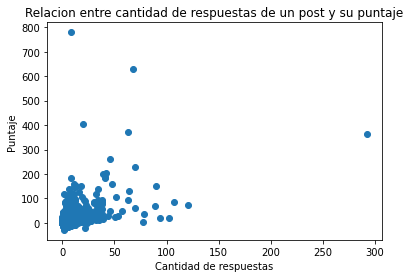

In [31]:
#Grafico
fig, ax = plt.subplots()  
mapeo_colores = ax.scatter(cantidad_respuestas, puntaje,)
plt.title('Relacion entre cantidad de respuestas de un post y su puntaje')
plt.xlabel('Cantidad de respuestas')
plt.ylabel('Puntaje')

### Top 10 tipo de post sin respuestas aceptadas

In [33]:
def filtrado(data):
    try:
        if data.attrib['PostTypeId'] == '1':
            if 'AcceptedAnswerId' in data.attrib:
                return
            else:
                numero = data.attrib['AnswerCount']
                titulo = data.attrib['Title']
                return numero, titulo
        else:
            return
    except:
        return
            

In [34]:
def mapper_pregunta(data):
    filtrados = list(map(filtrado, data))
    filtrados = list(filter(None, filtrados))
    return filtrados

In [35]:
HOME_DIR = Path.home()

tree = ET.parse(fr"{path.abspath('').replace('/notebooks','/datasets')}/posts.xml")
root = tree.getroot()
data_chunks = chunckify(root, 50)
mapped_pregunta = list(map(mapper_pregunta, data_chunks))
mapped_pregunta = reduce(fucionar_listas, mapped_pregunta)

In [37]:
preguntas = sorted(mapped_pregunta, reverse=True)
top10_pregunta = preguntas[0:10]
#Exportar resultados, ordenados de mayor cantidad de respuestas a menor
with open((fr"{path.abspath('').replace('/notebooks','/outputs')}/GD_r3_RespuestasSinAceptada.csv"), 'w') as f:
        f.write(str(top10_pregunta))                   
        f.close()

In [38]:
top10_pregunta = preguntas[0:10]
print(f'''Top10 de pregunta con mayor cantidad de respuesta sin respuesta aceptada:
1º Titulo: {top10_pregunta[0][1]} - Cantidad de respuestas: {top10_pregunta[0][0]}
2º Titulo: {top10_pregunta[1][1]} - Cantidad de respuestas: {top10_pregunta[1][0]}
3º Titulo: {top10_pregunta[2][1]} - Cantidad de respuestas: {top10_pregunta[2][0]}
4º Titulo: {top10_pregunta[3][1]} - Cantidad de respuestas: {top10_pregunta[3][0]}
5º Titulo: {top10_pregunta[4][1]} - Cantidad de respuestas: {top10_pregunta[4][0]}
6º Titulo: {top10_pregunta[5][1]} - Cantidad de respuestas: {top10_pregunta[5][0]}
7º Titulo: {top10_pregunta[6][1]} - Cantidad de respuestas: {top10_pregunta[6][0]}
8º Titulo: {top10_pregunta[7][1]} - Cantidad de respuestas: {top10_pregunta[7][0]}
9º Titulo: {top10_pregunta[8][1]} - Cantidad de respuestas: {top10_pregunta[8][0]}
10º Titulo: {top10_pregunta[9][1]} - Cantidad de respuestas: {top10_pregunta[9][0]}
''')

Top10 de pregunta con mayor cantidad de respuesta sin respuesta aceptada:
1º Titulo: Stack Overflow advertisement gallery - Cantidad de respuestas: 94
2º Titulo: Open Source Advertising - Sidebar - 1H 2010 - Cantidad de respuestas: 90
3º Titulo: Writing C++ expert on my CV - Cantidad de respuestas: 9
4º Titulo: Why should I upvote a question? - Cantidad de respuestas: 9
5º Titulo: Why doesn't the site use a rich text editor? - Cantidad de respuestas: 9
6º Titulo: Why do we need the trilogy instead of just one site? - Cantidad de respuestas: 9
7º Titulo: Where are the non-helpful people? - Cantidad de respuestas: 9
8º Titulo: When should you edit tags? - Cantidad de respuestas: 9
9º Titulo: What to do when a user deletes all their questions and answers? - Cantidad de respuestas: 9
10º Titulo: What should we do about questions marked correct that have obviously incorrect answers? - Cantidad de respuestas: 9

